Plotting Cusp Like Curve

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The shape of our curve has a discontinuity.

In [2]:
n_nodes = 100
s = np.linspace(0, 1, n_nodes)

In [3]:
def r(s, the):
    return np.array(np.sin(np.pi * s) * [np.cos((s-0.5)*the), np.sin((s-0.5)*the)])

In [4]:
x, y = r(s, 0.3)

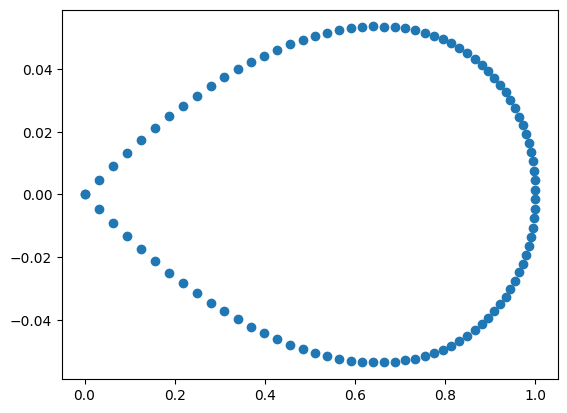

In [5]:
plt.scatter(x, y)
plt.show()

Checking Block Decomposition
$$
K^{\circ}_{fin} = P K^{\circ}_{coa} P^{T}_W
$$

In [6]:
import scipy.special as sps
import numpy as np
import matplotlib.pyplot as plt
n = 16
T, W, _ = sps.legendre(n).weights.T
def IPinit(T, W):
    #A and AA are vandermonde matrices.
    #Essentially 1, x,  x^2, etc.
    ##For AA we have 2n points so it is a larger Vandermonde matrix.
    ##
    A = np.ones((16, 16))
    AA = np.ones((32, 16))
    #From my understanding T2 is simply now 32 points which we interpolate down to
    T2 = np.empty((T.shape[0]*2))
    T2[:T.shape[0]] = (T-1)/2
    T2[T.shape[0]:] = (T+1)/2
    
    for k in range(1, 16):
        A[:, k] = A[:, k-1] * T
        AA[:, k] =  AA[:, k-1] * T2
    IP = AA @ np.linalg.inv(A)
    
    #Construct weighted interpolation matrix
    #rmultiply, multpiplies. corresponding elements
    W_coa = np.diag(W)
    
    W2 = np.empty(W.shape[0]*2)
    W2[:W.shape[0]] = W/2
    W2[W.shape[0]:] = W/2
    W_fin = np.diag(W2)
    
    IPW = W_fin @ IP @ np.linalg.inv(W_coa)
    
    return IP, IPW

/Users/hirish/miniforge3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
IP, IPW = IPinit(T, W)

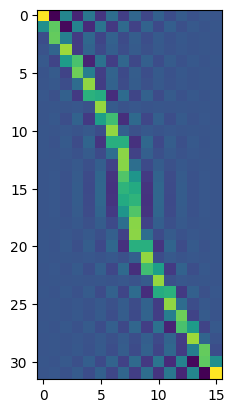

In [8]:
plt.imshow(IP)

In [9]:
def get_P_helper(num_blocks):
    IP, IPW = IPinit(T,  W)
    
    retMe = np.zeros(((num_blocks+2) * 16, num_blocks*16))
    retMe[16:-16,:] = np.eye(num_blocks*16)
    retMe[:32,:16] = IP
    retMe[-32:,-16:] = IP

    return retMe

def get_P(npan, nsub):
    P = get_P_helper(npan)
    for i in range(1, nsub):
        P = get_P_helper(npan+2*i) @ P
    return P
    #Note that IP takes us from a single panel to a double panel
    
def get_param_T(end1, end2):
    return (T+1)/2 * (end2-end1) + end1

def zinit_ellipse(T,W,npan):
    npoin = 16*npan #np is the number of points used for discretization in total

    #npan = 10
    sinter = np.linspace(0, 1, npan+1)
    sinterdiff = np.ones(npan)/npan

    s = np.zeros(npoin)
    w = np.zeros(npoin)

    for k in range(npan):
        start_in = k*16
        end_in = (k+1)*16
        #print(start_in, end_in)
        sdif = sinterdiff[k]/2
        #essentially s represents the parametrization from 0 to 1
        #We divide the values in T by 2 get a range -0.5 to 0.5
        #Then center it at the midpoint of each interval. Simple.
        s[start_in:end_in] = (sinter[k]+sinter[k+1])/2 + sdif*T
        #The weights are correspondingly scaled/2 since we are are transforming
        #from -1,1 to x,x+sinter
        w[start_in:end_in] = W*sdif
        """     z = zfunc_ellipse(s, a)
        zp = zpfunc_ellipse(s, a)
        zpp = zppfunc_ellipse(s, a)
        nz = -complex(0,1)*zp/np.abs(zp)
        wzp = w*zp """
    
    return s, w

def give_fine_mesh_parametrization_ellipse(nsub, npan):
    denom = 2 * npan

    #the first 2 panels closest to the singularity correspond
    #to tau^*
    start = 2/npan
    arr_endpoints = []
    for i in range(nsub+2):
        arr_endpoints.append(start)
        start /= 2
    arr_endpoints.append(0)

    parametrization = np.array([])
    param_weights = np.array([])
    for i in range(len(arr_endpoints)-1, 0, -1):
        #print(arr_endpoints[i],arr_endpoints[i-1])
        parametrization = np.append(parametrization ,get_param_T(arr_endpoints[i],arr_endpoints[i-1]))
        param_weights = np.append(param_weights, W*(arr_endpoints[i-1]-arr_endpoints[i]))



    start_ind = len(parametrization)
    otherpanels = np.linspace(2*(1/npan),1-2*(1/npan), npan-3)

    otherpanelsT = np.array([])
    otherweights = np.array([])
    for i in range(len(otherpanels)-1):
        otherpanelsT = np.append(otherpanelsT,get_param_T(otherpanels[i],otherpanels[i+1]))
        otherweights = np.append(otherweights, W*(otherpanels[i+1]-otherpanels[i]))

    end_in = start_ind + len(otherweights)

    parametrization = np.append(np.append(parametrization, otherpanelsT), list(reversed(1-parametrization)))
    weights = np.append(np.append(param_weights, otherweights), list(reversed(param_weights)))

    kcirc_indices = np.arange(start_ind, end_in)

    return parametrization, weights/2, kcirc_indices
    
def get_PW(npan, nsub):
    W_fin = give_fine_mesh_parametrization_ellipse(nsub, npan)[1]
    W_coarse = zinit_ellipse(T,  W, npan)[1]
    W_fin = np.diag(W_fin)
    W_coarse_inv = np.diag(1/W_coarse)
    P = get_P(npan, nsub)

    """ print("W_fin shape:", W_fin.shape)
    print("P shape:", P.shape)
    print("W_coarse shape:", W_coarse_inv.shape)  """

    PW = W_fin @ P @ W_coarse_inv

    return PW

In [10]:
npan = 10
PW = get_PW(npan,2)
P = get_P(npan,2)
#print("PW_P test", np.max(PW.T @ P - np.eye(16*npan)))

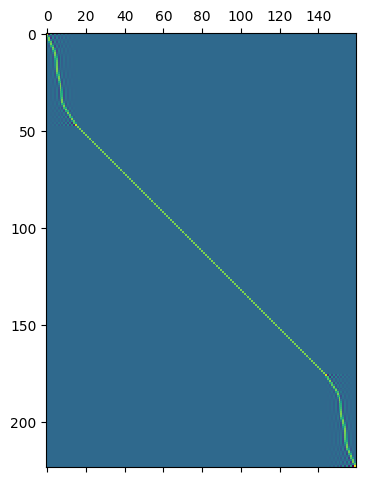

In [11]:
plt.matshow(P)

In [12]:
np.max(PW.T @ P - np.eye(16*npan))

8.227591144974777e-12

In [13]:
np.max(P @ PW.T - np.eye(224))

0.626696127990615

In [14]:
(P @ PW.T).shape

(224, 224)

In [15]:
import sympy as sp
class sympy_kernel:
    def __init__(self, aspect):
        import warnings
        warnings.filterwarnings("ignore")

        t_p = sp.Symbol('t_p')
        t = sp.Symbol('t')
        a = sp.Symbol('a')

        self.aspect = aspect
        self.t_p = t_p
        self.t = t
        self.a = a

        rp = sp.Matrix([a*sp.cos(2*sp.pi*t_p),sp.sin(2*sp.pi*t_p)])
        r = sp.Matrix([a*sp.cos(2*sp.pi*t),sp.sin(2*sp.pi*t)])
        vp = sp.Matrix([-sp.cos(2*sp.pi*t_p),-a*sp.sin(2*sp.pi*t_p)])/sp.sqrt((sp.cos(2*sp.pi*t_p))**2+(a*sp.sin(2*sp.pi*t_p))**2)

        numerator = (vp.T* (r-rp))[0]
        denominator = 2*sp.pi*((r-rp).T * (r-rp))[0]
        expr = numerator/denominator

        expr = expr.subs([(a, aspect)])
        self.expr = expr
        f = sp.utilities.lambdify([t,t_p],expr,"numpy")
        self.kernel_lambda = f

        expr2 = (r-rp).T * (r-rp)
        expr2 = expr2.subs([(a, aspect)])
        g = sp.utilities.lambdify([t,t_p],expr2,"numpy")

        self.cancellation = g
        
    def kernel_evaluate_equal(self, t_in):
        numerator = self.aspect
        denominator = (4*np.pi)*(self.aspect**2 * (np.sin(2*np.pi*t_in))**2 + (np.cos(2*np.pi*t_in))**2)**(1.5)
        return numerator/denominator

    def kernel_evaluate_exact(self, t_in, t_p_in):
        return float(self.expr.subs([(self.t,t_in),(self.t_p,t_p_in)]).evalf(20))

    def kernel_evaluate(self, t_in, t_p_in):
        return self.kernel_lambda(t_in, t_p_in) 

    def cancel_evaluate(self, t_in, t_p_in):
        return self.cancellation(t_in, t_p_in)
    
def get_K_circ_coarse(npan, aspect=3):
    s, w = zinit_ellipse(T, W, npan)
    npoin = s.shape[0]

    #In the paper K absorbs a factor of 2, my MAinit_ellipse doesn't have that factor of 2
    Kcirc = MAinit_ellipse(s, w, aspect)

    starind = [i for i in range(npoin-32,npoin)] #last two panels(16 points/per panel)
    starind += [i for i in range(32)] #first two panels (16 points/per panel)
    bmask = np.zeros((Kcirc.shape[0],Kcirc.shape[1]),dtype='bool')

    for i in starind:
        for j in starind:
            bmask[i,j]=1
    Kcirc[bmask] = 0

    return Kcirc    

def MAinit_ellipse(parametrization, weights, aspect):

    sympy_kern = sympy_kernel(aspect)
    npoin = parametrization.shape[0]
    D_K = np.zeros((npoin, npoin))
    for i in range(npoin):
        D_K[i,:] = sympy_kern.kernel_evaluate(parametrization[i],parametrization)
    for i in range(npoin):
        D_K[i,i] = sympy_kern.kernel_evaluate_equal(parametrization[i])

    W_shape = np.diag(weights * np.abs(zpfunc_ellipse(parametrization, aspect))[0])

    D_KW = D_K @ W_shape

    return 2*D_KW
def MAinitDL(z,zp,zpp,nz,w,wzp,npoin):
    import warnings
    warnings.filterwarnings("ignore", message="divide by zero encountered in divide")

    N = npoin
    M1 = np.zeros((N,N))
    ##Note that the formula for the Kernel is straightforward.
    for m in range(N):
        M1[:,m] = np.abs(wzp[m]) * (nz[m]/(z-z[m])).real

    for m in range(N):
        M1[m,m] = -(w[m]*(zpp/zp).imag/2)[m]

    warnings.filterwarnings("default", message="divide by zero encountered in divide")
    
    retMe = (M1/np.pi)

    return -retMe
def get_K_star_circ_fine(nsub, npan, aspect=3):
    param, weights, kcirc = give_fine_mesh_parametrization_ellipse(nsub, npan)

    z, zp, zpp, nz, w, wzp, npoin = zinit_ellipse_modified(param, weights, aspect)
    
    Kstar = MAinitDL(z,zp,zpp,nz,w,wzp,npoin)
    K = MAinitDL(z,zp,zpp,nz,w,wzp,npoin)
    kcirc = set(kcirc)

    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            if (i in kcirc) or (j in kcirc):
                Kstar[i,j] = 0

    return Kstar, (K-Kstar)
def zinit_ellipse_modified(s, w, a):
    #np is the number of points used for discretization in total
    z = zfunc_ellipse(s, a)[0]
    zp = zpfunc_ellipse(s, a)[0]
    zpp = zppfunc_ellipse(s, a)[0]
    nz = (-complex(0,1)*zp/np.abs(zp))
    wzp = (w*zp) 
    
    return z,zp,zpp,nz,w,wzp,z.shape[0]
def zfunc_ellipse(s, a):
    return np.array([
        a*np.cos(2*np.pi*s)+
        complex(0,1)*np.sin(2*np.pi*s)
        ])
def zpfunc_ellipse(s, a):
    return np.array([
        -2*np.pi*a*np.sin(2*np.pi*s)+
        2*np.pi*complex(0,1)*np.cos(2*np.pi*s)
        ])
def zppfunc_ellipse(s, a):
    return np.array([
        -((2*np.pi)**2)*a*np.cos(2*np.pi*s)+
        -((2*np.pi)**2)*complex(0,1)*np.sin(2*np.pi*s)
        ])

In [19]:
#def test_eq_16():
nsub = 2
npan = 10
aspect = 3
K_circ_fine = get_K_star_circ_fine(nsub, npan, aspect)[1]
K_circ_coarse = get_K_circ_coarse(npan, aspect)
P = get_P(npan, nsub)
PW = get_PW(npan, nsub)
print("EQ16",np.max(K_circ_fine - P@K_circ_coarse@PW.T))

EQ16 4.020568600271446e-14


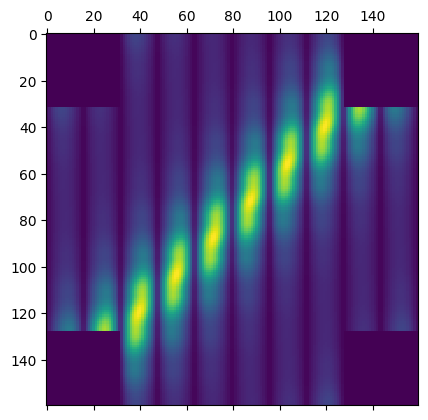

In [20]:
plt.matshow(K_circ_coarse)

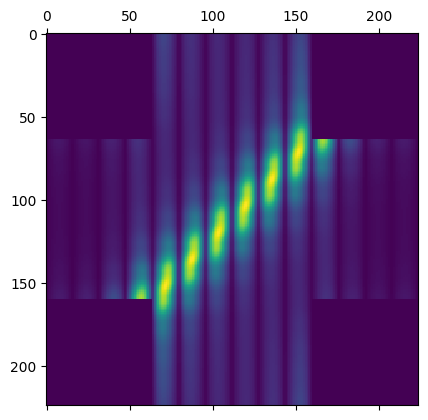

In [25]:
plt.matshow(K_circ_fine)

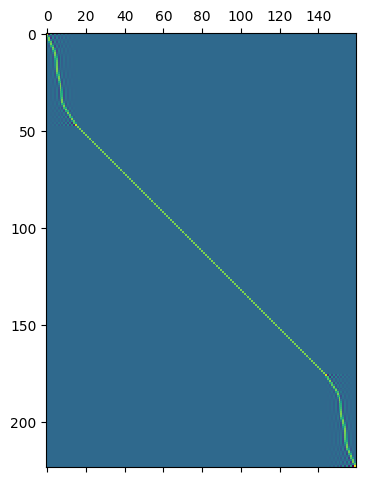

In [22]:
plt.matshow(P)